In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
df = pd.read_csv('translations_scores/mittens/system_mittens_gender_context_basic_metric.csv')

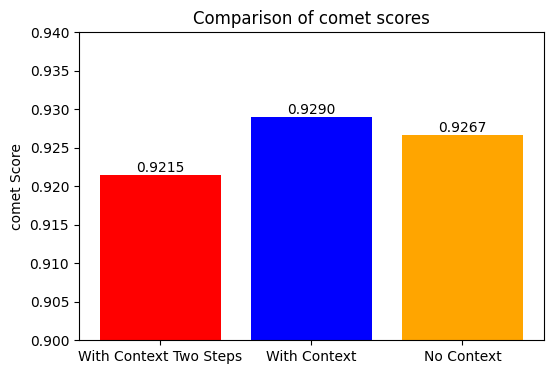

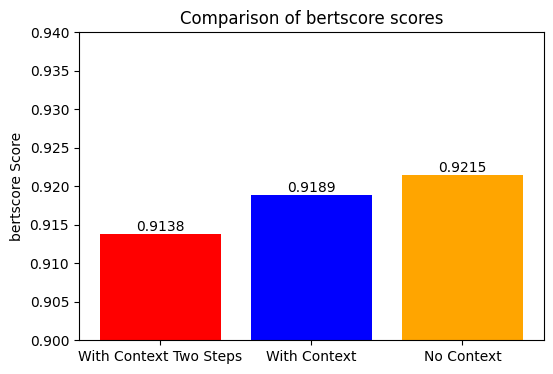

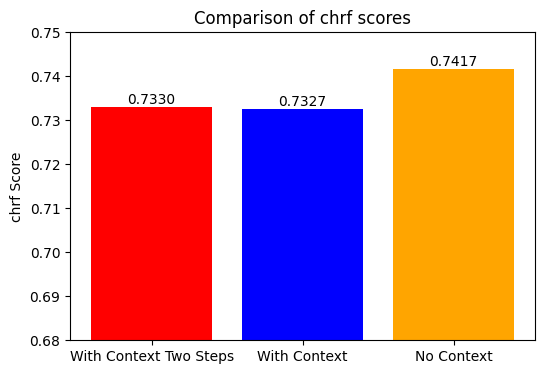

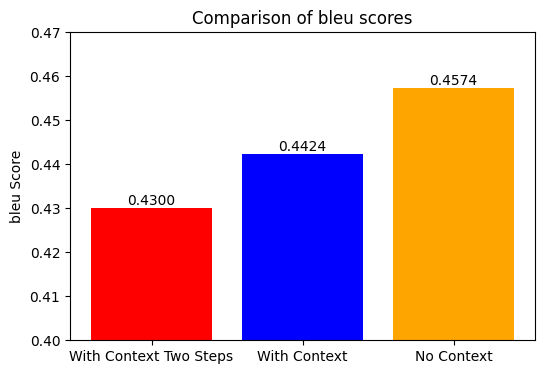

In [17]:
metrics = ['comet', 'bertscore', 'chrf', 'bleu']

# Tworzenie wykresów słupkowych
for metric in metrics:
    with_context_two_steps = df[f'{metric}_with_context_two_steps'].iloc[0]
    with_context = df[f'{metric}_with_context'].iloc[0]
    no_context = df[f'{metric}_no_context'].iloc[0]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(['With Context Two Steps', 'With Context', 'No Context'], [with_context_two_steps, with_context, no_context], color=['red','blue', 'orange'])
    plt.title(f'Comparison of {metric} scores')
    plt.ylabel(f'{metric} Score')

    
    if metric == "chrf":
        plt.ylim(0.68, 0.75)
    elif metric == "bleu":
        plt.ylim(0.4, 0.47)
    else:
        plt.ylim(0.9, 0.94)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')

    plt.show()

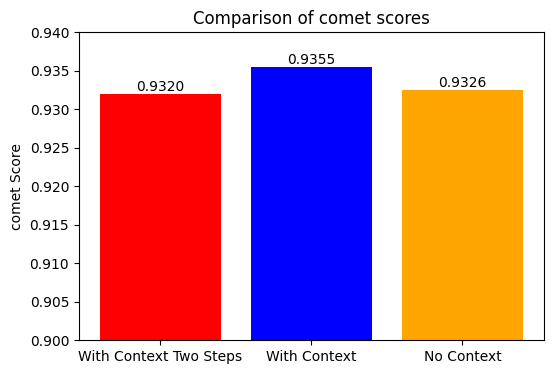

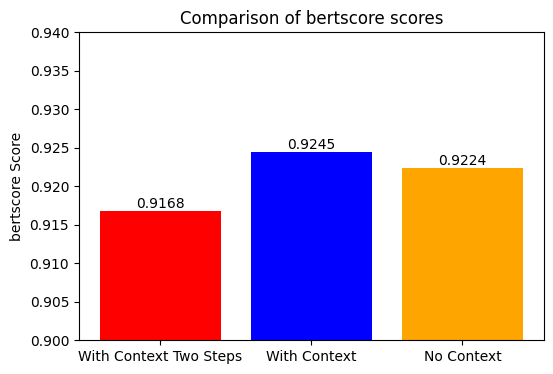

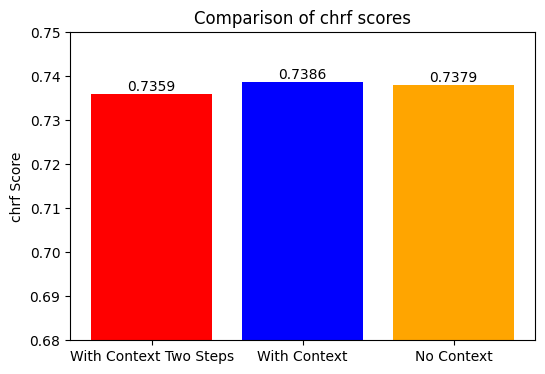

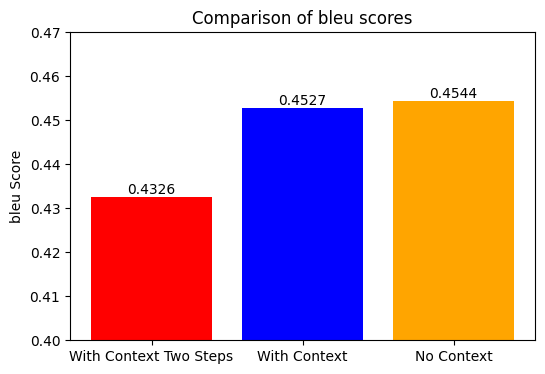

In [ ]:
metrics = ['comet', 'bertscore', 'chrf', 'bleu']

# Tworzenie wykresów słupkowych
for metric in metrics:
    with_context_two_steps = df[f'{metric}_with_context_two_steps'].iloc[0]
    with_context = df[f'{metric}_with_context'].iloc[0]
    no_context = df[f'{metric}_no_context'].iloc[0]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(['With Context Two Steps', 'With Context', 'No Context'], [with_context_two_steps, with_context, no_context], color=['red','blue', 'orange'])
    plt.title(f'Comparison of {metric} scores')
    plt.ylabel(f'{metric} Score')

    
    if metric == "chrf":
        plt.ylim(0.68, 0.75)
    elif metric == "bleu":
        plt.ylim(0.4, 0.47)
    else:
        plt.ylim(0.9, 0.94)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')

    plt.show()

In [8]:
from morfeusz2 import Morfeusz
morfeusz = Morfeusz()

In [11]:
df2 = pd.read_csv('results/mittens_gender_context.csv')

In [9]:
from collections import Counter

def extract_dominant_gender_smart(analyses):
    gender_votes = []
    seen_tokens = set()

    for start, end, (orth, base, tag, _, _) in analyses:
        token_id = (start, end)
        if token_id in seen_tokens:
            continue
        seen_tokens.add(token_id)

        tag_parts = tag.split(':')
        if not tag_parts:
            continue

        pos = tag_parts[0]
        gender = None


        # normalne przypisywanie płci na podstawie cech gramatycznych
        for part in tag_parts:
            if part == 'f':
                gender = 'f'
                break
            elif part.startswith('m') or part == 'n':
                gender = 'm'
                break

        if not gender:
            continue

        weight = 0

        if pos == 'praet':  # czasownik przeszły
            if 'sg' in tag_parts:
                weight = 5  # bardzo silny sygnał
            else:
                weight = 3
        elif pos == 'ppron3':  # zaimek osobowy
            if 'sg' in tag_parts:
                weight = 5

        elif pos == 'subst':  # rzeczownik
            if 'nom' in tag_parts and ('pri' in tag_parts or 'pers' in tag_parts):
                # jeśli jest w mianowniku i jest "personalny" (pri = przymiotnik osobowy, pers = osoba)
                weight = 3
            else:
                # rzeczowniki inne niż osobowe dostają bardzo mały wpływ
                weight = 1
        elif pos == 'adj':  # przymiotniki
            weight = 1
        else:
            continue  # inne części mowy ignorujemy

        gender_votes.extend([gender] * weight)

    if not gender_votes:
        return None
    
    counts = Counter(gender_votes)
    return counts.most_common(1)[0][0]

def is_gender_match(sentence, expected_gender):
    morf = morfeusz
    analysis = morf.analyse(sentence)
    gender = extract_dominant_gender_smart(analysis)

    if not gender:
        return False

    return gender == expected_gender

In [12]:
no_context_good = 0
no_context_bad = 0
with_context_good = 0
with_context_bad = 0
with_context_two_steps_good = 0
with_context_two_steps_bad = 0

for index, row in df2.iterrows():
    gender = 'm' if row['encoded_gender'] == "masculine" else 'f'
    
    text_no_context = row['no_context']
    text_with_context = row['with_context']
    text_with_context_two_steps = row['with_context_two_steps']

    result_no_context = is_gender_match(text_no_context, gender)
    result_with_context = is_gender_match(text_with_context, gender)
    result_with_context_two_steps = is_gender_match(text_with_context_two_steps, gender)

    if result_no_context:
        no_context_good += 1
    else:   
        no_context_bad += 1

    if result_with_context:
        with_context_good += 1
    else:
        with_context_bad += 1

    if result_with_context_two_steps:
        with_context_two_steps_good += 1
    else:
        with_context_two_steps_bad += 1

print("No context accuracy: ", no_context_good / (no_context_good + no_context_bad))
print("Good: ", no_context_good)
print("Bad: ", no_context_bad)
print("With context accuracy: ", with_context_good / (with_context_good + with_context_bad))
print("Good: ", with_context_good)
print("Bad: ", with_context_bad)
print("With context two steps accuracy: ", with_context_two_steps_good / (with_context_two_steps_good + with_context_two_steps_bad))
print("Good: ", with_context_two_steps_good)
print("Bad: ", with_context_two_steps_bad)

No context accuracy:  0.82
Good:  123
Bad:  27
With context accuracy:  0.8866666666666667
Good:  133
Bad:  17
With context two steps accuracy:  0.94
Good:  141
Bad:  9


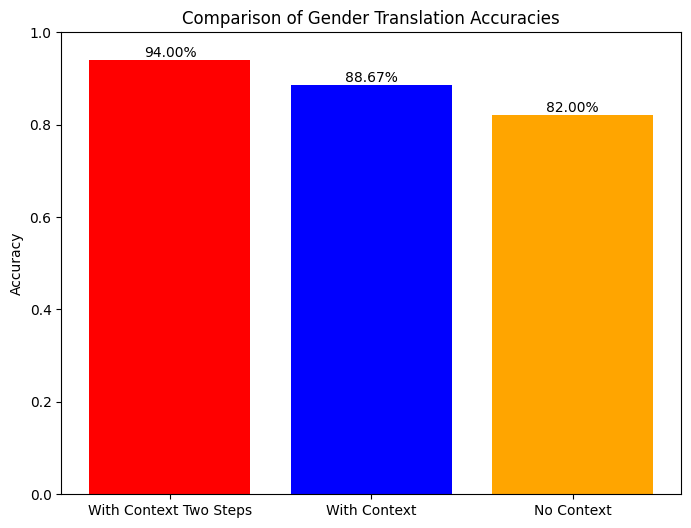

In [15]:
import matplotlib.pyplot as plt

# Accuracies calculated from the data
no_context_accuracy = no_context_good / (no_context_good + no_context_bad)
with_context_accuracy = with_context_good / (with_context_good + with_context_bad)
with_context_two_steps_accuracy = with_context_two_steps_good / (with_context_two_steps_good + with_context_two_steps_bad)

# Data for the bar plot
contexts = ['With Context Two Steps', 'With Context', 'No Context']
accuracies = [with_context_two_steps_accuracy, with_context_accuracy, no_context_accuracy]

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(contexts, accuracies, color=['red', 'blue',  'orange'])

# Add accuracy values on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2%}', ha='center', va='bottom')

# Add labels and title
plt.title('Comparison of Gender Translation Accuracies')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits to 0-1 for percentage representation

# Show the plot
plt.show()